In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Embedding, Bidirectional, LSTM


In [3]:
file_path = '/content/drive/My Drive/sentiment_analysis/data/train.csv'

In [4]:
df = pd.read_csv(file_path, encoding='latin-1')

In [5]:
df.sample(5)

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
255636,0,1984534817,Sun May 31 15:17:50 PDT 2009,NO_QUERY,bsansbury,Is pooping her pants as she has got a maths ex...
421771,0,2062493356,Sat Jun 06 23:23:35 PDT 2009,NO_QUERY,LadyLeshurr,@phatfffat that picture scared the life out of...
443740,0,2067639161,Sun Jun 07 12:41:57 PDT 2009,NO_QUERY,SeraFemmeCloud9,@alanajoy I miss you too!! Hit me up if you ev...
21148,0,1557224409,Sun Apr 19 02:45:32 PDT 2009,NO_QUERY,GTHvidsten,Turned on TV to see the F1 champagne ceremony ...
1275388,4,2001086591,Mon Jun 01 23:48:09 PDT 2009,NO_QUERY,TempKat,The crowd is loving Jay-Z! He's growing his ha...


In [6]:
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']
df.head()

,target,id,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [7]:
df = df[['target', 'text']]

In [8]:
df.head()

,target,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


In [9]:
df.isna().sum()

target    0
text      0
dtype: int64

In [10]:
df['target'].unique()

array([0, 4])

In [11]:
df['target'] = df['target'].replace(4,1)

In [12]:
df_1 = df.copy()

<ipython-input-13-289f64b9d492>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'target', data = df_1, palette = 'viridis')


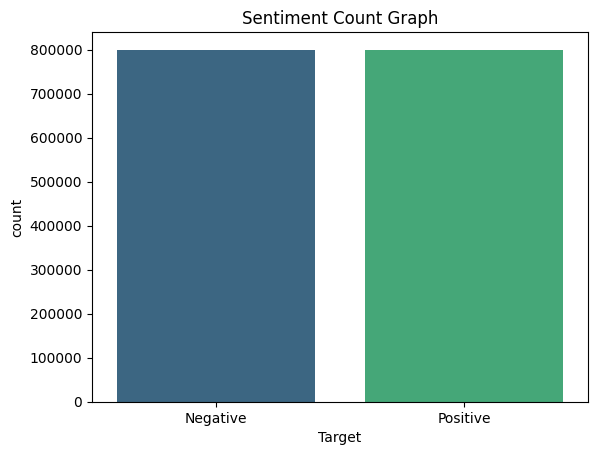

In [13]:
import seaborn as sns
df_1['target'] = df_1['target'].replace({0: 'Negative', 1: 'Positive'})
sns.countplot(x = 'target', data = df_1, palette = 'viridis')
plt.title('Sentiment Count Graph')
plt.xlabel('Target')
plt.show()

In [14]:
df.head()

,target,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


In [17]:
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import re

to_remove = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
stopwords_ = stopwords.words('english')
stemmer = SnowballStemmer("english")



In [18]:
def preprocess_text(text, stem=False):

    text = re.sub(to_remove, ' ', text.lower()).strip()
    tokens = text.split()
    tokens = [token for token in tokens if token not in stopwords_]
    if stem:
        tokens = [stemmer.stem(token) for token in tokens]
    return " ".join(tokens)

In [19]:
%%time
df['processed_text'] = df.text.apply(lambda x: preprocess_text(x, stem=True))

CPU times: user 2min 1s, sys: 245 ms, total: 2min 1s
Wall time: 2min 3s


In [20]:
X = df.processed_text
y = df.target

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=48)


In [22]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1279999,) (320000,) (1279999,) (320000,)


In [23]:
X_train

458394             haha would love scare get troubl suckssss
116237     2 book summer read list come slow start work c...
362725     came back dentist root canal done pain still g...
33619       morn tweetland far fox given reason harass wrong
838723     yes realli look forward beautifi 1 25 acr sage...
                                 ...                        
1295302                    woo l rling plass hos hotel union
636736     unfortun runnin chicken sausag manag get 3 tas...
829787              broke even fun wait till right vega babi
1537476          knock twice 20min whenev song come sun come
920115     wow great night see www francisrodino com scal...
Name: processed_text, Length: 1279999, dtype: object

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size:', vocab_size)

max_length = max([len(seq) for seq in X_train])
print('Maximum sequence length:', max_length)

Vocabulary size: 248827
Maximum sequence length: 50


In [25]:
X_train

[[50, 58, 7, 546, 2, 956, 13006],
 [32, 237, 155, 136, 490, 38, 611, 75, 5, 282, 43],
 [342,
  16,
  1106,
  1930,
  4840,
  116,
  355,
  29,
  11,
  6015,
  332,
  913,
  1132,
  5537,
  3569],
 [42, 15556, 269, 2128, 1486, 457, 7965, 311],
 [87, 24, 37, 285, 22318, 120, 1223, 11751, 86007, 1593],
 [10484,
  4267,
  424,
  1309,
  6440,
  9944,
  15,
  92,
  44770,
  3218,
  1,
  7911,
  25,
  37,
  130],
 [32, 80, 74, 543, 22, 6, 49],
 [1224, 455, 108],
 [266, 1999, 1710, 2],
 [1398, 101, 1635, 12009, 136],
 [17143, 933, 785],
 [593, 111, 355, 25296, 10648],
 [170, 5097, 22, 1, 6],
 [958, 2741, 201, 34, 1181, 3911, 75, 2369],
 [5325, 96, 2, 1873, 59, 5, 134],
 [7, 142, 8, 65, 135, 8, 3077, 492, 649, 8, 1503, 8, 246, 82],
 [28, 1233, 85, 665, 99, 162, 4543, 9084, 863, 4492, 88],
 [50, 13, 18, 18, 235, 54, 235, 18],
 [87],
 [128,
  45,
  3,
  931,
  10,
  2292,
  525,
  6050,
  1302,
  22319,
  25,
  7168,
  481,
  3504,
  25,
  3274,
  6441],
 [266, 1834, 14323, 1287, 120, 22320],
 [

In [26]:
X_train[0]

[50, 58, 7, 546, 2, 956, 13006]

In [27]:
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

In [28]:
X_train[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,    50,    58,
           7,   546,     2,   956, 13006], dtype=int32)

In [29]:
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)


X_train: (1279999, 50)
X_test: (320000, 50)


In [30]:
model = Sequential()

In [31]:
model.add(Input(shape = max_length, ))
model.add(Embedding(input_dim = vocab_size, output_dim = max_length))
model.add(LSTM(128, return_sequences = True))
model.add(LSTM(128))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [32]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            12441350  
                                                                 
 lstm (LSTM)                 (None, 50, 128)           91648     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12672903 (48.34 MB)
Trainable params: 12672903 (48.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
history = model.fit(X_train, y_train, validation_split=0.1, epochs=2, batch_size=128, verbose=1)

Epoch 1/2
9000/9000 [==============================] - 3547s 394ms/step - loss: 0.3764 - accuracy: 0.8297 - val_loss: 0.4840 - val_accuracy: 0.7780
Epoch 2/2
9000/9000 [==============================] - 3392s 377ms/step - loss: 0.3297 - accuracy: 0.8517 - val_loss: 0.5157 - val_accuracy: 0.7692


In [38]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 332s 33ms/step - loss: 0.5062 - accuracy: 0.7740


[0.5061654448509216, 0.7739593982696533]

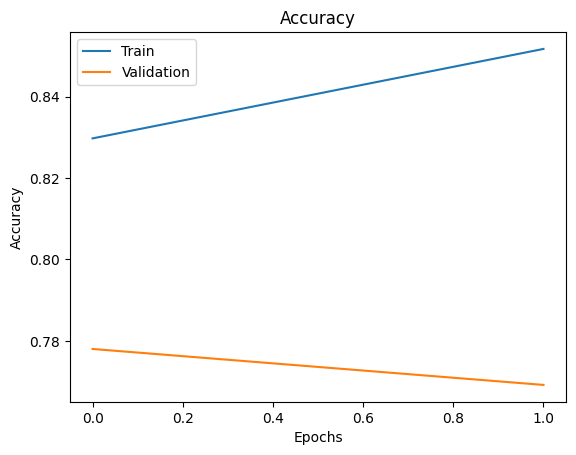

In [42]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'],loc = 'upper left')
plt.show()

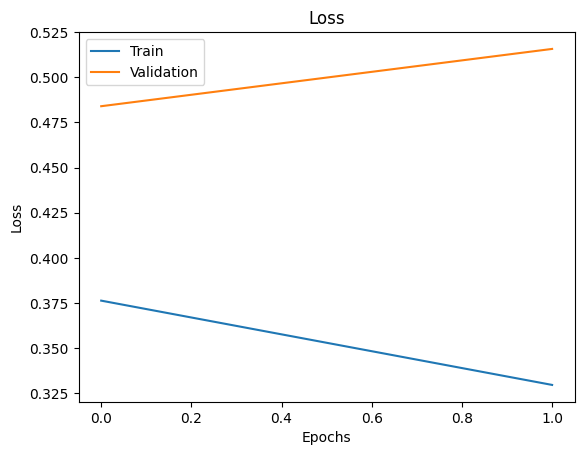

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

In [39]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype('int')

10000/10000 [==============================] - 310s 31ms/step


In [40]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print('Classification Report: \n', classification_report(y_test, y_pred))

Classification Report: 
               precision    recall  f1-score   support

           0       0.77      0.79      0.78    160183
           1       0.78      0.76      0.77    159817

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



<Axes: >

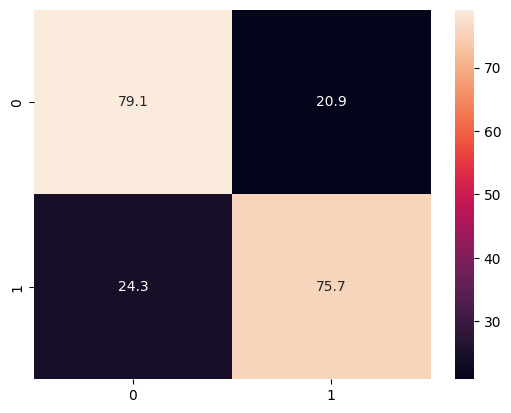

In [47]:
import seaborn as sns

total_per_class = cm.sum(axis=1)
percentage_matrix = (cm / total_per_class[:, None]) * 100

sns.heatmap(percentage_matrix, annot=True, fmt=".1f")